## Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс Недвижимость, представляющие собой объявления о продаже квартир в Санкт-Петербурге и соседних населенных пунктах.

Задача: установить рыночную стоимость квартир, какие параметры влияют на ценообразование квартир.

## **Описание данных:**

In [1]:
# импортирую библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

In [2]:
#код ревьюера
try:
    data = pd.read_csv('/--', sep='\t')
except:
    data = pd.read_csv(
    '/---/real_estate_data.csv', sep='\t'
    )
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [4]:
# сразу переименую столбец "до центра города"
data = data.rename(columns={'cityCenters_nearest' : 'city_center_nearest'})

In [5]:
# посмотрим сколько данных у нас отсутствует
data.isna().sum()
#data.isna().sum()/len(data)*100

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_center_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Мне необходимо избавиться от пропусков в значениях. Для начала я буду групировать по парам свойства и заполнять медианными значениями. Так меньше шанс допустить ошибку. 

In [6]:
# раздадим медианные значения по группировке площадь - кол-во комнат
data['kitchen_area'] = (data['kitchen_area']
    .fillna(data.groupby(['total_area', 'rooms'])['kitchen_area']
    .transform('median'))
)
# если комнат 0, скорее всего это студия, в студии примем площадь кухни 5метров
data[data['studio'] == True].loc[data['rooms'] == 0, 'kitchen_area'] = 5

# найдем медианные значения в группировке комнаты-жилая площадь
data['kitchen_area'] = (data['kitchen_area']
    .fillna(data.groupby(['rooms', 'living_area'])['kitchen_area']
    .transform('median'))
)
# найдем медианные значения в группировке суммарная площадь-жилая площадь
data['kitchen_area'] = (data['kitchen_area']
    .fillna(data.groupby(['total_area', 'living_area'])['kitchen_area']
    .transform('median'))
)
# доочистим оставшиеся по кол-ву комнат
data['kitchen_area'] = (data['kitchen_area']
    .fillna(data.groupby('rooms')['kitchen_area']
    .transform('median'))
)

In [7]:
# найдем жилую площадь как медианную по площади квартир и комнатам
data['living_area'] = (data['living_area']
    .fillna(data.groupby(['total_area', 'rooms'])['living_area']
    .transform('median'))
)

data['living_area'] = (data['living_area']
    .fillna(data.groupby(['total_area', 'kitchen_area'])['living_area']
    .transform('median'))
)

data['living_area'] = (data['living_area']
    .fillna(data.groupby(['rooms', 'kitchen_area'])['living_area']
    .transform('median'))
)

data['living_area'] = (data['living_area']
    .fillna(data.groupby('rooms')['living_area']
    .transform('median'))
)

In [8]:
# посмотрим имеются ли объявления, в которых суммарная площадь меньше 
# суммы жилой и кухонной площадей
display(data.query('total_area < living_area + kitchen_area'))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_center_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
184,7,2600000.0,30.20,2018-02-14T00:00:00,1,2.65,9.0,26.10,5,NaN,...,6.20,NaN,Санкт-Петербург,13952.0,15031.0,0.0,NaN,1.0,824.0,12.0
424,14,11500000.0,98.00,2016-05-10T00:00:00,3,2.65,3.0,88.00,3,False,...,14.00,1.0,Санкт-Петербург,39363.0,13270.0,0.0,NaN,0.0,NaN,90.0
440,8,2480000.0,27.11,2018-03-12T00:00:00,0,NaN,17.0,24.75,4,NaN,...,6.00,2.0,Санкт-Петербург,38171.0,15015.0,0.0,NaN,2.0,982.0,64.0
545,9,4700000.0,23.80,2018-12-28T00:00:00,1,NaN,18.0,20.00,9,NaN,...,5.00,NaN,Санкт-Петербург,9731.0,11849.0,0.0,NaN,0.0,NaN,108.0
551,8,3100000.0,31.59,2018-03-08T00:00:00,1,2.70,19.0,30.55,2,NaN,...,9.28,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22907,9,65000000.0,228.00,2016-06-02T00:00:00,4,NaN,5.0,200.00,2,NaN,...,33.20,NaN,Санкт-Петербург,22783.0,1295.0,3.0,619.0,3.0,269.0,NaN
23102,0,5800000.0,66.00,2017-06-09T00:00:00,5,NaN,5.0,55.50,1,NaN,...,15.00,0.0,Санкт-Петербург,12007.0,11933.0,0.0,NaN,0.0,NaN,21.0
23191,3,1900000.0,18.90,2016-04-04T00:00:00,1,NaN,16.0,16.00,12,NaN,...,9.00,0.0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,115.0
23202,13,4919880.0,67.92,2018-10-23T00:00:00,2,NaN,3.0,63.00,3,NaN,...,13.04,NaN,Всеволожск,NaN,NaN,NaN,NaN,NaN,NaN,60.0


In [9]:
# таких данных 172 штуки, это менее 1 процента всех данных
# полагаю что от этих данных можно избавиться
data = data.query('total_area > living_area + kitchen_area')

In [10]:
# там где отсутствуют значения балконов сделаем их равными нулю
data['balcony'] = data['balcony'].fillna(0)

In [11]:
# где отсутствуют значения апартаментов, будем считать что это не апартаменты
data['is_apartment'] = data['is_apartment'].where(data['is_apartment'].isin([True]), False)
#display(data.query('is_apartment == True'))

In [12]:
# поскольку высота потолков зависит от многих данных, например года постройки, конкретного
# месторасположения квартиры и прочих данных, которыми мы не располагаем
# применю метод с медианами по кол-ву комнат

data['ceiling_height'] = (data['ceiling_height']
    .fillna(data.groupby('rooms')['ceiling_height']
    .transform('median'))
)
# остается ОДНА квартира, что с ней не так?!
# выпилю ее, если не найду причину!!!!

In [13]:
# посмотрим что же за уникальный объект у нас остался
data['ceiling_height'] = (data['ceiling_height']
    .fillna(data.groupby('total_area')['ceiling_height']
    .transform('median'))
)

In [14]:
# проверим какие есть вообще значения этажности дома
display(data['floors_total'].value_counts())
# 60й этаж кажется подозрительным, посмотрим где находится квартира
display(data.query('floors_total == 60'))
# в Кронштадте точно нет небоскребов, скорее всего это ошибка
data.loc[data['floors_total'] == 60, 'floors_total'] = 6

5.0     5745
9.0     3735
16.0    1355
12.0    1351
4.0     1188
10.0    1167
25.0    1050
6.0      899
17.0     824
3.0      657
7.0      585
14.0     547
18.0     492
24.0     459
8.0      387
2.0      374
15.0     363
23.0     345
19.0     329
22.0     279
20.0     268
13.0     227
11.0     201
27.0     160
21.0     150
26.0     123
35.0      23
1.0       23
28.0      21
36.0       3
34.0       1
60.0       1
29.0       1
33.0       1
52.0       1
37.0       1
Name: floors_total, dtype: int64

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_center_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
2253,12,3800000.0,45.5,2018-06-28T00:00:00,2,2.88,60.0,27.4,4,False,...,7.4,0.0,Кронштадт,67763.0,49488.0,2.0,342.0,3.0,614.0,166.0


In [15]:
# days_exposition не буду менять не на что, поскольку, вероятно, если нет значения - объявление еще не снято
# заменю его на 0
data['days_exposition'] = data['days_exposition'].fillna(0)

In [16]:
# что делать с суммарным количеством этажей тоже не понятно, поскольку не ясно как восстановить
# данные
data['floors_total'] = data['floors_total'].fillna(0)
data.query('floors_total == 0')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_center_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
186,12,11640000.0,65.2,2018-10-02T00:00:00,2,2.60,0.0,30.80,4,False,...,12.00,0.0,Санкт-Петербург,39197.0,12373.0,1.0,123.0,0.0,NaN,49.0
237,4,2438033.0,28.1,2016-11-23T00:00:00,1,2.64,0.0,20.75,1,False,...,6.80,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,251.0
457,4,9788348.0,70.8,2015-08-01T00:00:00,2,2.60,0.0,38.40,12,False,...,10.63,0.0,Санкт-Петербург,37364.0,8322.0,2.0,309.0,2.0,706.0,727.0
671,4,6051191.0,93.6,2017-04-06T00:00:00,3,2.65,0.0,47.10,8,False,...,16.80,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,123.0
1757,5,3600000.0,39.0,2017-04-22T00:00:00,1,2.64,0.0,18.00,9,False,...,10.00,0.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22542,5,8500000.0,63.5,2017-05-24T00:00:00,2,2.80,0.0,32.75,3,False,...,11.00,0.0,Санкт-Петербург,51340.0,15363.0,0.0,NaN,1.0,853.0,512.0
22656,4,4574160.0,64.5,2017-04-02T00:00:00,2,2.60,0.0,31.70,20,False,...,14.40,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,127.0
22808,0,14569263.0,110.4,2016-11-20T00:00:00,3,2.65,0.0,45.38,6,False,...,23.42,0.0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,260.0
23590,0,21187872.0,123.3,2017-04-25T00:00:00,3,2.65,0.0,50.40,18,False,...,23.60,0.0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,104.0


In [17]:
# просмотрим все уникальные значения названий населенных пунктов
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [18]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е', regex=True)

In [19]:
# с пропусками в названии населенного пункта поступим так - мы не можем ни по каким данным
# его воспроизвести, так что следует заменить его на 'unknown'
data['locality_name'] = data['locality_name'].fillna('unknown')

In [20]:
# заменю расстояние до центра медианными значениями по сгруппированным по стоимости квартир данным


data['city_center_nearest'] = (data['city_center_nearest']
    .fillna(data.groupby(['locality_name'])['city_center_nearest']
    .transform('median'))
)

data['city_center_nearest'] = round(data['city_center_nearest'] / 1000)


In [21]:
# заменю расствояние до аэропорта
data['airports_nearest'] = (data['airports_nearest']
                               .fillna(data.groupby(['locality_name', 'last_price'])['airports_nearest']
                               .transform('median'))
                              )


Данные о расстоянии до аэропорта, ближайшего пруда/парка и кол-во прудов и парков не фигурируют в дальнейших расчетах, поэтому избавляться от всех пропусков не вижу смысла.

In [22]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              1
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5365
city_center_nearest      4809
parks_around3000         5413
parks_nearest           15412
ponds_around3000         5413
ponds_nearest           14397
days_exposition             0
dtype: int64

In [23]:
# проверим на дубликаты
data.duplicated().sum()

0

### ИЗМЕНЕНИЕ ТИПОВ ДАННЫХ

Ниже - список изменений типов данных, который я хочу произвести:
* floors_total --> int потому что кол-во этажей не может быть дробным
* first_day_exposition --> datetime потому что это дата
* is apartment --> bool потому что содержит только True и False
* balcony --> int потому что кол-во балконов не может быть дробным
* days_exposition --> int потому что кол-во дней не может быть дробным
* parks_around --> int (но остались данные с пропусками, так что менять не буду)
* ponds_around --> int (но остались данные с пропусками, так что менять не буду)

In [24]:
data['floors_total'] = data['floors_total'].astype('int')
data['is_apartment'] = data['is_apartment'].astype('bool')
data['balcony'] = data['balcony'].astype('int')
data['days_exposition'] = data['days_exposition'].astype('int')
# parks_around
# ponds_around

## ВЫЧИСЛЕНИЯ

### ВЫЧИСЛЕНИЕ СТОИМОСТИ КВАДРАТНОГО МЕТРА**

In [25]:
# добавлю в таблицу столбец, в котором будет посчитана стоимость за кв. метр
data['meters_price'] = (data['last_price'] / data['total_area']).round(2)

### ДОБАВЛЕНИЕ В ТАБЛИЦУ ДНЯ НЕДЕЛИ, МЕСЯЦА И ГОДА ОБЪЯВЛЕНИЯ

In [26]:
data['time_data'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S') 
# добавлю столбец с номером месяца методом month
data['month'] = data['time_data'].dt.month
# добавлю столбец с номером дня методом weekday
data['weekday'] = data['time_data'].dt.weekday
# добавлю столбец с номером года методом year
data['year'] = data['time_data'].dt.year
#time_grouped.head()

In [27]:
month_dict = {
    1 : 'Январь',
    2 : 'Февраль',
    3 : 'Март',
    4 : 'Апрель',
    5 : 'Май',
    6 : 'Июнь',
    7 : 'Июль',
    8 : 'Август',
    9 : 'Сентябрь',
    10 : 'Октябрь',
    11 : 'Ноябрь',
    12 : 'Декабрь'    
}

data['month_name'] = data['month'].map(month_dict)

In [28]:
day_dict = {
    0 : 'Понедельник',
    1 : 'Вторник',
    2 : 'Среда',
    3 : 'Четверг',
    4 : 'Пятница',
    5 : 'Суббота',
    6 : 'Воскресенье'
}

data['day_name'] = data['weekday'].map(day_dict)

**3. ДОБАВЛЕНИЕ В ТАБЛИЦУ КАТЕГОРИЙ ЭТАЖЕЙ**

In [29]:
# напишу функцию, котрая будет присваивать значения по этажам.
# если в исходной таблице не указано общее кол-во этажей, функция вернет значение "неизвестен"

def what_floor(row):
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    if row['floors_total'] == 0:
        return 'неизвестен'
    if row['floor'] != 1 and row['floor'] != row['floors_total']:
        return 'другой'
# добавлю в основную таблицу
data['floor_name'] = data.apply(what_floor, axis=1)

### СООТНОШЕНИЯ ПЛОЩАДЕЙ

In [30]:
data['living_to_total'] = (data['living_area'] / data['total_area']).round(2)
data['kitchen_to_total'] = (data['kitchen_area'] / data['total_area']).round(2)

## ИССЛЕДОВАНИЕ

### ГИСТОГРАММА ДЛЯ ЦЕНЫ НА КВАРТИРУ

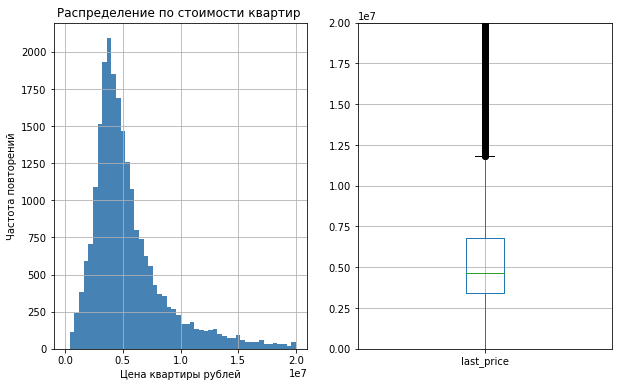

In [31]:
plt.figure(figsize=(10,6))
ax = plt.subplot(1, 2, 1)
plt.hist(data['last_price'], bins=50, range=(0, 20000000), color='#4682B4')
plt.xlabel('Цена квартиры рублей')
plt.ylabel('Частота повторений')
plt.title('Распределение по стоимости квартир ')
plt.grid(True)

plt.subplot(1, 2, 2)
data.boxplot('last_price')
plt.ylim(0, 20000000)
plt.show()

In [32]:
# квартиры, стоимостью менее 1млн рублей можно также считать аномальными. Аномально низкими.
# таких данных 1%.
print(data.query('last_price <= 1000000').count()/len(data)*100)

total_images            1.020670
last_price              1.020670
total_area              1.020670
first_day_exposition    1.020670
rooms                   1.020670
ceiling_height          1.020670
floors_total            1.020670
living_area             1.020670
floor                   1.020670
is_apartment            1.020670
studio                  1.020670
open_plan               1.020670
kitchen_area            1.020670
balcony                 1.020670
locality_name           1.020670
airports_nearest        0.004271
city_center_nearest     0.004271
parks_around3000        0.004271
parks_nearest           0.004271
ponds_around3000        0.004271
ponds_nearest           0.000000
days_exposition         1.020670
meters_price            1.020670
time_data               1.020670
month                   1.020670
weekday                 1.020670
year                    1.020670
month_name              1.020670
day_name                1.020670
floor_name              1.020670
living_to_

Анализ данных показал, что 3% квартир - квартиры, стоимостью более 20млн рублей, 1% квартир - квартиры менее 1млн рублей. И те и другие данные принимаю как аномальные и исключаю.

In [33]:
data = data.query('last_price < 20000000 and last_price > 1000000')

### ГИСТОГРАММА ДЛЯ ПЛОЩАДИ

Среди всех квартир, что представлены нам есть и очень маленькие и очень большие по площади квартиры. Построю гистограмму для всех площадей, не буду ничего исключать на данном этапе.

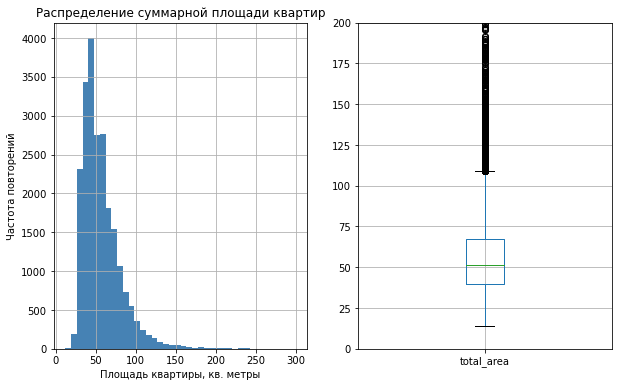

In [34]:
# построю гистаграмму для суммарной площади
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(data['total_area'], bins=40, range=(12, 300), color='#4682B4')
# задам подпись оси х
plt.xlabel('Площадь квартиры, кв. метры')
# задам подпись оси у
plt.ylabel('Частота повторений')
# задам название графика
plt.title('Распределение суммарной площади квартир')
# добавлю линии сетки
plt.grid(True)

plt.subplot(1, 2, 2)
data.boxplot('total_area')
plt.ylim(0, 200)

plt.show()

In [35]:
print('Доля квартир, площадь которых более 250кв. метров:')
print(data.query('total_area >= 250').count() / len(data) * 100)

Доля квартир, площадь которых более 250кв. метров:
total_images            0.031165
last_price              0.031165
total_area              0.031165
first_day_exposition    0.031165
rooms                   0.031165
ceiling_height          0.031165
floors_total            0.031165
living_area             0.031165
floor                   0.031165
is_apartment            0.031165
studio                  0.031165
open_plan               0.031165
kitchen_area            0.031165
balcony                 0.031165
locality_name           0.031165
airports_nearest        0.031165
city_center_nearest     0.031165
parks_around3000        0.031165
parks_nearest           0.013356
ponds_around3000        0.031165
ponds_nearest           0.008904
days_exposition         0.031165
meters_price            0.031165
time_data               0.031165
month                   0.031165
weekday                 0.031165
year                    0.031165
month_name              0.031165
day_name                0

In [36]:
# удалим те квартиры, площадь которых более 250кв. метров (всего 5 квартир)
data = data.query('total_area <= 250')

**вывод:**

Исходя из гистограммы хорошо видно распределение площадей квартир. Основная масса представленных квартир - малометражные. Медианные значения приходятся на ~50 квадратных метров. Есть и гигантские квартиры (можно ли их назвать квартирами) в 900 кв. метров, но цена у этой квартиры, соответствующая, так что мы оставим это значение в таблице.

### ГИСТОГРАММА ДЛЯ КОЛИЧЕСТВА КОМНАТ

В данных по кол-ву комнат присутствуют совершенно разные, например, имеются квартиры, где 0 комнат, возможно это квартиры с открытой планировкой, или студии, а возможно - какая-то ошибка. Есть квартиры, в которых > 5 комнат. И уж совсем сомнительные 19 комнат. С другой стороны, если это какой-то особняк или коттедж, то это вполне вероятно.

In [37]:
# всего квартир, в которых комнат 0: 197 штук, из них 138 - студии
data.query('rooms == 0').groupby(['studio'])['studio'].count()
# 59 - c открытой планировкой
data.query('rooms == 0').groupby(['open_plan'])['open_plan'].count()

open_plan
False    106
True      46
Name: open_plan, dtype: int64

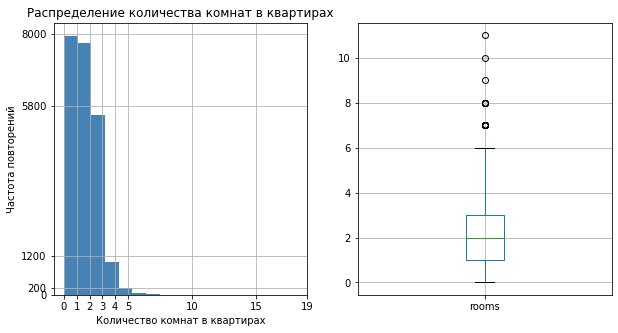

In [38]:
plt.figure(figsize=(10,5))
ax = plt.subplot(1, 2, 1)
# данные для гистограммы
plt.hist(data['rooms'], range=(0,16), bins=15, color='#4682B4')
# значения для оси х
ax.set_xticks([0, 1, 2, 3, 4, 5, 10, 15, 19])
# для оси у
ax.set_yticks([0, 200, 1200, 5800, 8000])
plt.ylabel('Частота повторений')
plt.xlabel('Количество комнат в квартирах')
plt.title('Распределение количества комнат в квартирах')
plt.grid(True)
# диаграмма размаха
plt.subplot(1, 2, 2)
data.boxplot('rooms')
plt.show()

In [39]:
# проверим сколько квартир с кол-вом комнат больше 6
data.query('rooms > 6').count()/len(data)*100

total_images            0.115787
last_price              0.115787
total_area              0.115787
first_day_exposition    0.115787
rooms                   0.115787
ceiling_height          0.115787
floors_total            0.115787
living_area             0.115787
floor                   0.115787
is_apartment            0.115787
studio                  0.115787
open_plan               0.115787
kitchen_area            0.115787
balcony                 0.115787
locality_name           0.115787
airports_nearest        0.115787
city_center_nearest     0.115787
parks_around3000        0.115787
parks_nearest           0.093520
ponds_around3000        0.115787
ponds_nearest           0.053440
days_exposition         0.115787
meters_price            0.115787
time_data               0.115787
month                   0.115787
weekday                 0.115787
year                    0.115787
month_name              0.115787
day_name                0.115787
floor_name              0.115787
living_to_

Посмотрим на квартиры, количество комнат в которых больше или равно 7, сгруппируем по кол-ву комнат и выведем медиану площадей этих квартир, можно предположить что если в квартире суммарная площадь более 150 метров, то там возможно наличие столь большого количества комнат. Такие квартиры выбиваются из "средних" значений, однако выкидывать их мы не можем.

In [40]:
data.query('rooms >= 7').groupby('rooms')['total_area'].median()

rooms
7     175.0
8     229.0
9     235.0
10    216.1
11    183.7
Name: total_area, dtype: float64

**вывод:**

Полученные данные указывают на то что медианным значением количества комнат является - 2 комнаты. Минимальным значением кол-ва комнат является 0 - и это так же не является ошибкой, потому что все эти квартиры либо студии, либо квартиры с открытой планировкой, так что, возможно, в таких квартирах просто нельзя выделить определенное кол-во комнат. Есть квартиры, в которых кол-во комнат выше 7, однако суммарная площадь этих объектов превышает 150 кв. метров, так что мы можем предположить что это также нормально и оставить данные, не удаляя их. Однако, для нашего исследования важно избавиться от выбросов, и рассматривать именно средние значения, так что удалим все данные, где кол-во комнат более 6.

In [41]:
# удалим все данные, кол-во комнат в которых больше  6
data = data.query('rooms <= 6')

### ГИСТОГРАММА СТОИМОСТИ КВАРТИРЫ ЗА КВАДРАТНЫЙ МЕТР

In [42]:
data['meters_price'].max()

392354.12

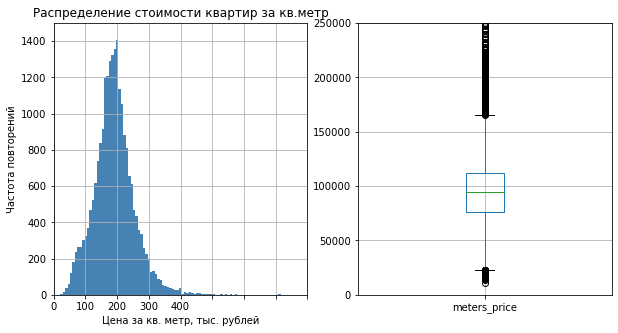

In [43]:
plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
plt.hist(data['meters_price'], bins=100, color='#4682B4')
plt.axis([0, 400000, 0, 1500])
#plt.xlim(0, 400000)
ax.set_xticklabels(['0', '100', '200', '300', '400'])
plt.xlabel('Цена за кв. метр, тыс. рублей')
plt.ylabel('Частота повторений')
plt.title('Распределение стоимости квартир за кв.метр')
plt.grid(True)

plt.subplot(1, 2, 2)
data.boxplot('meters_price')
plt.ylim(0, 250000)
plt.show()

Из очевидного - квартиры в Санкт-Петербурге не могут стоить ниже 36 тыс. рублей за кв.метр
https://lenta.ru/news/2020/06/14/spb_minimum/
Поэтому данные, удовлетворяющие условию - СПБ и менее 36 тыс. рублей за кв. метр, являются аномально низкими.

In [44]:
data.query('meters_price <= 30000')[['locality_name', 'meters_price']]

,locality_name,meters_price
170,поселок Торковичи,19047.62
431,Луга,24285.71
487,поселок Оредеж,19877.68
703,Пикалево,20905.92
724,Кириши,26136.36
...,...,...
23434,поселок Громово,26271.19
23458,поселок Возрождение,24733.27
23477,Гатчина,10507.25
23490,Тихвин,28125.00


In [45]:
# удалим квартиры в СПБ, кв. метр, которых менее 36тыс руб.,
#а так же квартиры, кв.метр которых менее 20тыс руб

data = (data
.query(
    '(meters_price >= 36000 and locality_name == "Санкт-Петербург") or meters_price >=20000')
       )

**вывод:**

Цены за квадратный метр квартиры варьируются в широком диапазоне. Можно сказать одно - в среднем стоимость квадратного метра для большинства квартир - около 100 тысяч рублей. Квартиры, стоимость одного квадратного метра в Санкт-Петербурге меньше 36 метров, а также квартиры, стоимость кв. метра которых меньше 20тыс рублей, должны быть исключены из таблицы, как аномально низкие.

### ГИСТОГРАММА ВЫСОТЫ ПОТОЛКОВ

In [46]:
# по нормативным документам минимальная разрешенная высота потолков - 2 метра 40 см, 
# максимальная не регламентируется, но редко превышает высоту в 4 метра 20 см
# таким образом нормальными будут потолки в этом промежутке
data.query('ceiling_height > 2.40 and ceiling_height < 4.20')
# аномально высокие потолки
display(data.query('ceiling_height > 4.20')['ceiling_height'].count())
# аномально низкие потолки
display(data.query('ceiling_height < 2.40')['ceiling_height'].count())

data = data.query('ceiling_height > 2.40 and ceiling_height < 4.20')

38

20

In [47]:
# посчитаем долю оставшихся данных, относительно исходных
len(data) / 23699 * 100

94.12633444449133

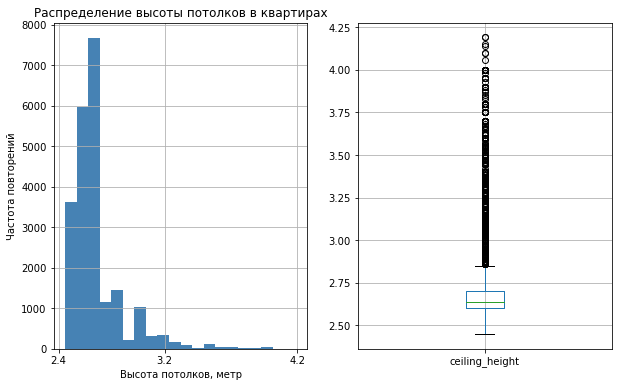

In [48]:
plt.figure(figsize=(10,6))
ax = plt.subplot(1, 2, 1)
plt.hist(data['ceiling_height'], bins=20, color='#4682B4')
ax.set_xticks([2.40, 3.20, 4.20])
plt.xlabel('Высота потолков, метр')
plt.ylabel('Частота повторений')
plt.title('Распределение высоты потолков в квартирах')
plt.grid(True)

plt.subplot(1, 2, 2)
data.boxplot('ceiling_height')
#plt.ylim(0, 5)
plt.show()

**вывод:**

Очевидно что в квартирах не может быть потолков, ниже 2метров 40см, это прописано в нормативных документах. Исходя из данных видно, что некоторое кол-во людей указало что высота потолков в их квартирах - меньше этого минимально допустимого норматива. Эти данные, скорее всего подлежат удалению, или приведению к нижнему стандарту для данной категории. В случае с значениями потолков, выше 4.20 метров также имеются вопросы. Можно допустить, поскольку нет верхнего предела, что высота потолков будет превышать 4 метра, однако такое возможно либо в частных домах, либо в Сталинских постройках в Москве. При этом значения > 5 метров явно являются ошибкой, и подлежат исключению.

**ЗАДАНИЕ 1**

Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?

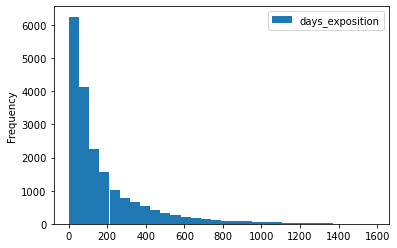

In [49]:
(data
.query('not days_exposition == 0')
.plot(y='days_exposition', kind='hist', bins=30)
)
plt.show()

Медианым значением дней по продаже является:  74.0 дней.
Средним  значением дней по продаже является:  155.66844488277223 дней.


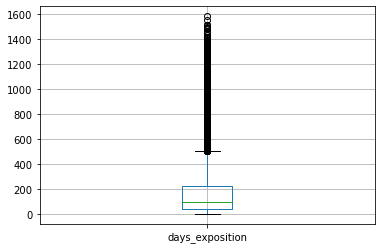

In [50]:
# для того чтобы точнее увидеть какие значения считать нормой, а какие выбиваются - построю 
# график "ящик с усами"
(data
.query('not days_exposition == 0')
.boxplot('days_exposition')
)
print('Медианым значением дней по продаже является: ', data['days_exposition'].median(), 'дней.')
print('Средним  значением дней по продаже является: ', data['days_exposition'].mean(), 'дней.')

In [51]:
test_1 = data.query('days_exposition != 0 and days_exposition < 365')
test_1['days_exposition'].describe()

count    16599.000000
mean       104.341225
std         89.276900
min          1.000000
25%         37.000000
50%         74.000000
75%        153.000000
max        364.000000
Name: days_exposition, dtype: float64

**вывод:**

Медианным значением продажи является - 74 дня, Средним - 157 дней.
При построении гистограмм убраны значения, в которых стоит значение 0, поскольку, предполагается, что такие объявления все еще висят и квартиры не проданы.
Получается аномально быстрые продажи совершаются в срок до 1 месяца (<30 дней).
Аномально долгими продажами стоит считать те, что висят больше 200 дней.

Если отсечь значения, больше 365, и посмотреть описание, получается что среднее значение уменьшится: с 157 дней до 105 дней, медианное значение не меняется.

**ЗАДАНИЕ 2**

* Изучить какие факторы влияют на ценообразование квартиры
* от суммарной площади
* чила комнат
* этажа
* удаленности от центра

а также:
* от дня недели
* от месяца
* от города

### влияние метража квартиры на ее цену

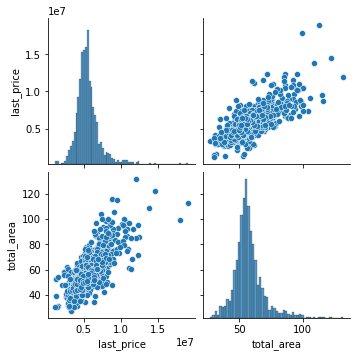

In [52]:
# как влияет метраж квартиры на ее стоимость
data_grouped = (
    data
    .query('last_price < 20000000 and total_area <= 250')
    .pivot_table(index='first_day_exposition', values=['last_price', 'total_area'], aggfunc='mean')
)    

#pd.plotting.scatter_matrix(data_grouped, figsize=(9,9), color='#4682B4')
#print(data_grouped.corr())

sns.pairplot(data_grouped)
plt.show()
# если ограничивать верхний порог цены и верхний порог метража мы будем наблюдать снижение
# коэффициента корреляции с 0.77 до 0.65

**вывод**

Метраж квартиры в значительной степени влияет на конечное ценообразование квартиры.

### зависимость количества комнат в квартире на ее цену

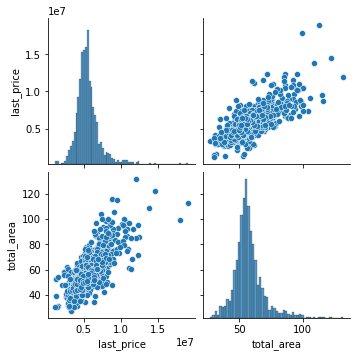

            last_price     rooms
last_price    1.000000  0.468441
rooms         0.468441  1.000000


In [53]:
price_on_rooms = (
    data
    .query('last_price < 20000000 and rooms <= 6')
    .pivot_table(index='first_day_exposition', values=['last_price', 'rooms'], aggfunc='mean')
)    

#pd.plotting.scatter_matrix(price_on_rooms, figsize=(9,9), color='#4682B4')
sns.pairplot(data_grouped)
plt.show()
print(price_on_rooms.corr())

**вывод:**

Количество комнат влияет сильно на ценообразование квартиры.

Если строить диаграмму и считать коэффициент корреляции без ограничений, получется что он равен 0.34, то есть ко-во комнат очень слабо влияет на ценообразование. Это и понятно, поскольку одинаковое кол-во комнат может быть при совершенно разной площади квартир. Так что зависимость, по-видимому, описывается более сложной моделью.

Если мы отсечем квартиры, стоимостью более 20млн, и кол-во комнат оставим меньше или равное 5 - то коэффициент корреляции увеличится до 0.47. 


### зависимость цены квартиры от этажа

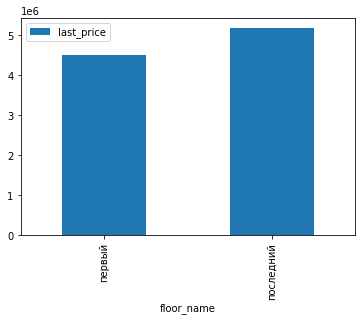

In [54]:
# построим столбчатую диаграмму, для того чтобы посмотреть среднюю стоимость квартиры на первом и последнем
# этажах
exp = (data
    .query('floor_name == "первый" or floor_name == "последний"')
    .pivot_table(index=['floor_name'], values=['last_price'], aggfunc='mean')
    .plot(kind='bar')
)

Очевидно что квартиры на последнем этаже стоят несколько дороже, однако прямой сильной зависимости нет.

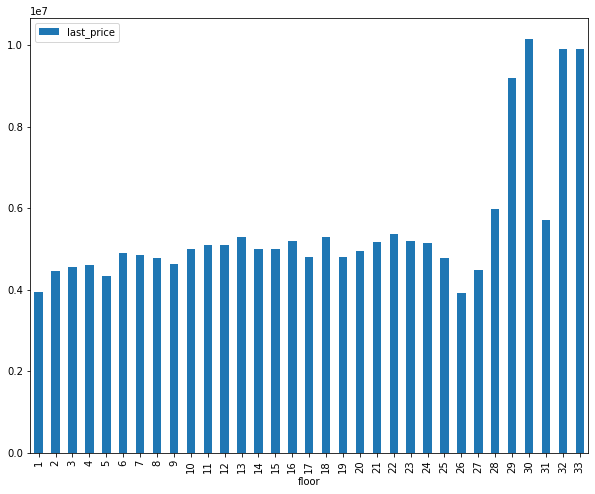

In [55]:
# диаграмма распределения средних цен по каждому этажу
(data
    .pivot_table(index='floor', values=['last_price'], aggfunc='median')
    .plot(kind='bar', figsize=(10,8))
)
plt.show()

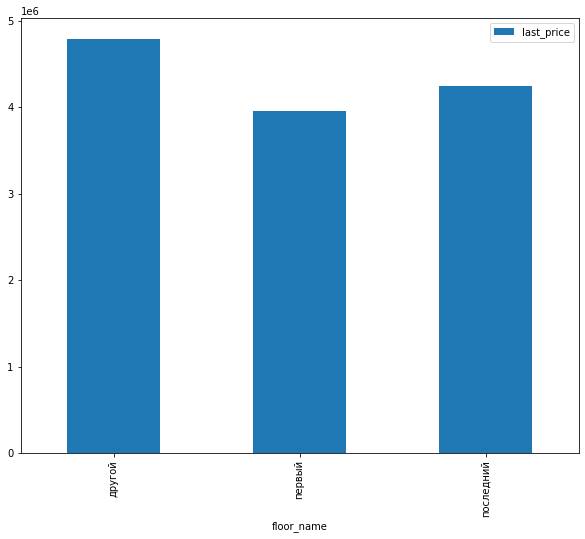

In [56]:
# диаграмма распределения средних цен по группам "первый"-"последний"-"другой"
# поскольку считается, что на первых и последних этажах жить не хотят
# возможно, средняя цена у "другого" будет выше
(data
    .query('floor_name != "неизвестен"')
    .pivot_table(index='floor_name', values=['last_price'], aggfunc='median')
    .plot(kind='bar', figsize=(10,8))
)
plt.show()

Наблюдается динамика в сторону увеличения цены (от первого этажа - к более высокому), резкое увеличение цены происходит у квартир, находящихся на этажах от 28, это, полагаю, можно объяснить тем, что такие квартиры находятся в небоскребах (или домах выше средних), а квартиры в таких домах, в среднем, стоят дороже.

В целом, подтверждается заключение, сделаный ранее - квартиры на последних этажах стоят дороже, чем на первых.

### влияние удаленности от центра на цену квартиры

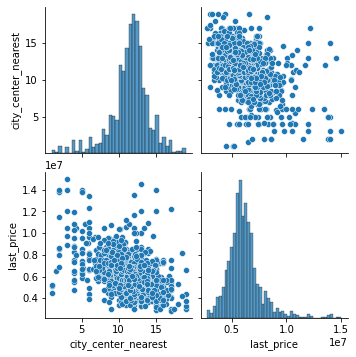

                     city_center_nearest  last_price
city_center_nearest             1.000000   -0.458792
last_price                     -0.458792    1.000000


In [57]:
# как влияет расстояние до центра города на ее стоимость
price_on_centr = (
    data
    .query('last_price <= 15000000 and city_center_nearest < 20')
    .pivot_table(index='first_day_exposition', values=['last_price', 'city_center_nearest'], aggfunc='mean')
)    

#pd.plotting.scatter_matrix(price_on_centr, figsize=(9,9), color='#4682B4')

sns.pairplot(price_on_centr)
plt.show()
print(price_on_centr.corr())

In [58]:
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_center_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'meters_price', 'time_data',
       'month', 'weekday', 'year', 'month_name', 'day_name', 'floor_name',
       'living_to_total', 'kitchen_to_total'],
      dtype='object')

**вывод**

Мы наблюдаем обратную корреляцию - чем меньше расстояние до центра, тем выше цена квартиры.

### влияние дня недели, в который выложено объявление на цену квартиры

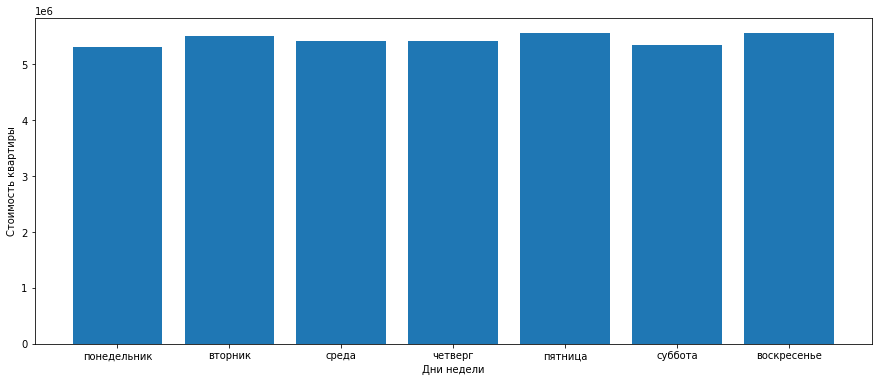

In [59]:
plt.figure(figsize=(15, 6))
day = ['понедельник', 'вторник', 'среда', 'четверг', 'пятница', 'суббота', 'воскресенье']
plt.bar(day, data.groupby('day_name')['last_price'].mean())

plt.xlabel('Дни недели')
plt.ylabel('Стоимость квартиры')
plt.show()

**вывод**

Неважно в какой день недели выкладывается объявление о продаже квартиры. Влияния нет.

### влияние месяца года, в который выложено объявление на цену квартиры

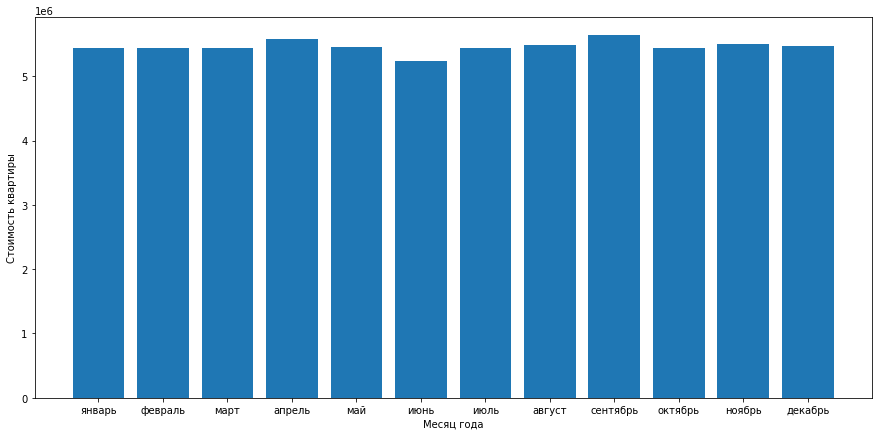

In [60]:
plt.figure(figsize=(15, 7))
mon = ['январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль', 'август', 'сентябрь', 'октябрь', 'ноябрь', 'декабрь']
plt.bar(mon, data.groupby('month')['last_price'].mean())

plt.xlabel('Месяц года')
plt.ylabel('Стоимость квартиры')
plt.show()

**вывод**

Неважно в какой месяц выкладывается объявление о продаже квартиры. Влияния нет.

### влияние года, в который выложено объявление на цену квартиры

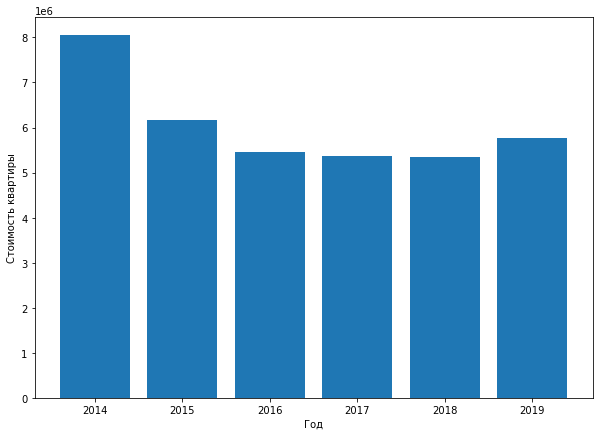

In [61]:
plt.figure(figsize=(10, 7))
#plt.scatter(data['year'], data['last_price'])

plt.bar(range(2014, 2020), data.groupby('year')['last_price'].mean())
plt.xlabel('Год')
plt.ylabel('Стоимость квартиры')
plt.show()

**вывод**

При анализе данных - средней стоимости квартиры в зависимости от года выставления объявления на продажу можно выделить 2014 год - квартиры, в среднем здесь стоят дороже. Это может быть связано с чем угодно, в частности с политической ситуацией в стране, и курсом валюты.

**ВЫВОД**

На ценообразование влияют такие параметры, как:
* общий метраж квартиры (в большей степени). коэффициент корреляции~0.77
* количество комнат (опосредованно). С увеличением комнат увеличивается, как правило, и суммарная площадь квартиры. Коэффициент корреляции ~0.47
* расстояние до центра города - отрицательная корреляция - чем меньше расстояние, тем выше стоимость квартиры. После определенного расстояния, это влияние уменьшается. Чем ближе к центру - тем стоимость выше.
* в целом, квартиры на последнем этаже стоят дороже, чем те, что на первом этаже

На ценообразование не влияют:
* день, месяц и год выставления объявления



**ЗАДАНИЕ 3**

* Выбрать 10 населеных пунктов с наибольшим числом объявлений
* Посчитать среднюю цену квадратного метра
* Посчитать наименьшую и наибольшую цену квадратного метра в выборке

In [62]:
# сгруппируем данные по городам и стоимосте за кв. метр
city_separation = (
    data
    .pivot_table(index='locality_name', values='meters_price', aggfunc = ('count', 'median'))
)
# переименуем колонки
city_separation.columns = ['count', 'median']
# отсортируем по убыванию кол-ва объявлений
city_separation.sort_values(by='count', ascending=False, inplace=True)
# отсавим первые 10
city_separation = city_separation.head(10)
display(city_separation)
# наибольшая средняя цена за кв. метр
print('Наибольшая средняя цена за кв. метр: ', city_separation['median'].max(), 'рублей, в Санкт-Петербурге')
# наименьшая средняя цена за кв. метр
print('Наименьшая средняя цена за кв. метр: ', city_separation['median'].min(), 'рублей, в Выборге')

,count,median
locality_name,,
Санкт-Петербург,14776,103339.885
поселок Мурино,526,84801.380
поселок Шушары,437,76666.670
Всеволожск,385,65686.270
Пушкин,354,99596.340
Колпино,335,74725.270
поселок Парголово,325,91642.860
Гатчина,299,67796.610
деревня Кудрово,287,91803.280


Наибольшая средняя цена за кв. метр:  103339.88500000001 рублей, в Санкт-Петербурге
Наименьшая средняя цена за кв. метр:  58546.82 рублей, в Выборге


**ЗАДАНИЕ 4**

Понять какая область входит в понятие "центр".
* собрать данные по Санкт-Петербургу
* округлить значения расстояния до целого числа
* построить диаграмму
* определить центр
* рассчитать среднюю стоимость для каждого километра

In [63]:
test = (
    data
    .query('locality_name == "Санкт-Петербург" and last_price < 900000000')
    .pivot_table(index='city_center_nearest', values='last_price', aggfunc='mean')
)
# в таблице средние значения для средней стоимости квартиры по каждому км вплоть до 30км.
test.head()

,last_price
city_center_nearest,
0.0,9.981667e+06
1.0,1.055320e+07
2.0,9.898652e+06
3.0,8.945454e+06
4.0,9.336809e+06


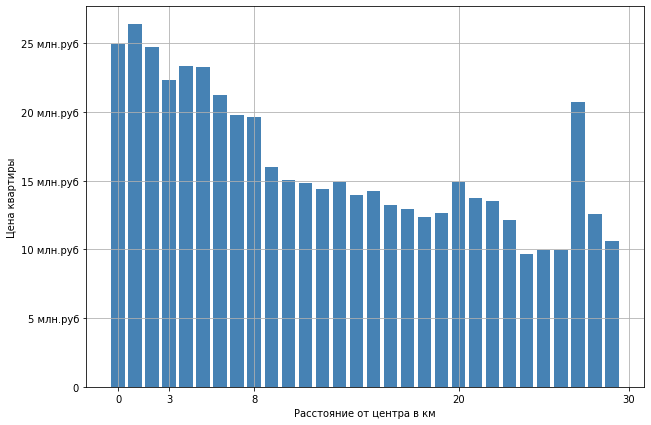

In [64]:
plt.figure(figsize=(10,7))
ax = plt.subplot()
plt.bar(range(len(test)), test['last_price'], color='#4682B4')
ax.set_xticks([0, 3, 8, 20, 30])
ax.set_yticklabels(['0', '5 млн.руб', '10 млн.руб', '15 млн.руб', '20 млн.руб', '25 млн.руб', '30 млн.руб'])
plt.xlabel('Расстояние от центра в км')
plt.ylabel('Цена квартиры')
plt.grid(True)

plt.show()
# всплеск на 25 км могу объяснить тем, что значения пропущенные в колонке "до центра города"
# я заменила на 25км

**вывод**

Итак, могу отметить расстояние в 8км, после этого значения средняя стоимость квартир возрастает. Таким образом - все что в пределах 8ми км является центром.

In [65]:
# применю к датасету фильтры и сохраню это в новой переменной
# это все квартиры в Питере в центре 
piter_center = data.query('locality_name == "Санкт-Петербург" and city_center_nearest <= 8 and total_area <= 400 and last_price <= 200000000 and rooms <= 8') 


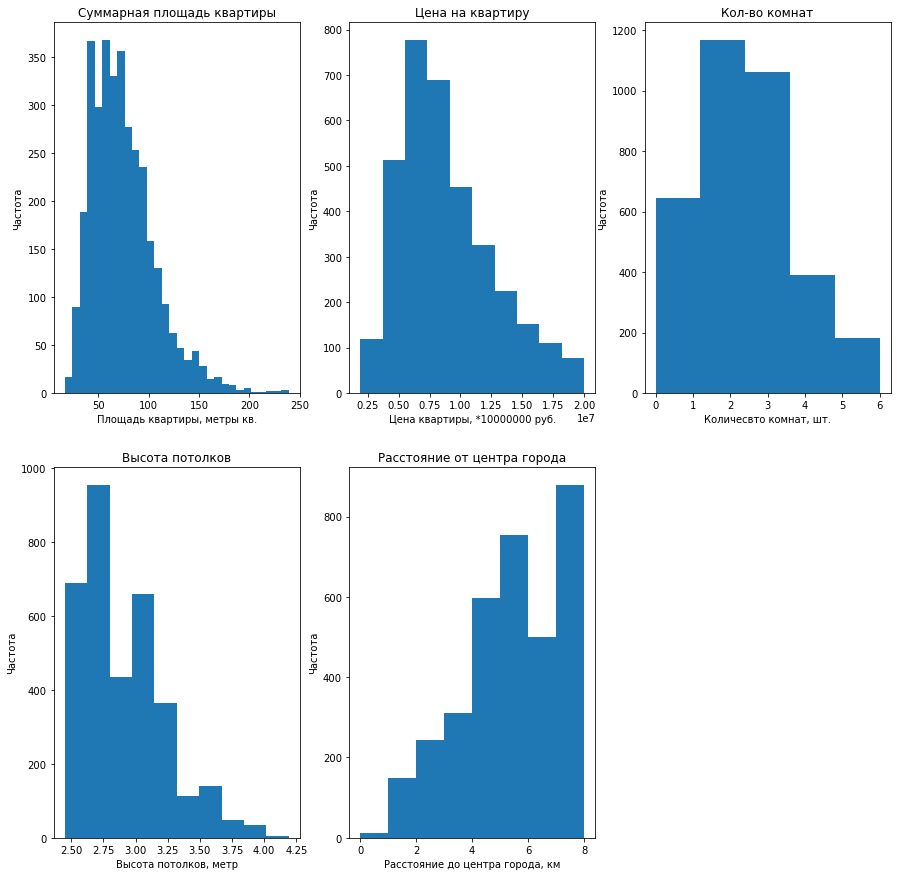

In [66]:
# построю все гистограммы в одной картинке
plt.figure(figsize=(15, 15))

plt.subplot(2, 3, 1)
plt.hist(piter_center['total_area'], bins=30)
plt.title('Суммарная площадь квартиры')
plt.xlabel('Площадь квартиры, метры кв.')
plt.ylabel('Частота')

plt.subplot(2, 3, 2)
plt.hist(piter_center['last_price'])
plt.title('Цена на квартиру')
plt.xlabel('Цена квартиры, *10000000 руб.')
plt.ylabel('Частота')

plt.subplot(2, 3, 3)
plt.hist(piter_center['rooms'], bins=5)
plt.title('Кол-во комнат')
plt.xlabel('Количесвто комнат, шт.')
plt.ylabel('Частота')

plt.subplot(2, 3, 4)
plt.hist(piter_center['ceiling_height'])
plt.title('Высота потолков')
plt.xlabel('Высота потолков, метр')
plt.ylabel('Частота')

plt.subplot(2, 3, 5)
plt.hist(piter_center['city_center_nearest'], bins=8)
plt.title('Расстояние от центра города')
plt.xlabel('Расстояние до центра города, км')
plt.ylabel('Частота')

plt.show()


В целом показатели не сильно меняются от того, что мы видели до выборки.

Итак:
* суммарная площадь сместилась в сторону увеличения - то есть если раньше медиана была в районе 50кв.метров, а теперь - ближе к 100кв.метрам.
* средняя стоимость квартиры увеличилась с 4млн рублей до ~10 млн. рублей
* количество комнат - среднее значение было около 2х комнат, теперь сместилось к 3м комнатам.
* высота потолков осталась без изменений

In [67]:
summary = pd.DataFrame(
[['ср.знач. площади квартиры для Центра Питера', round(piter_center['total_area'].mean()), 'кв. метр'],
 ['ср.знач. площади квартиры для исходных данных', round(data['total_area'].mean()), 'кв. метр'],
 ['ср.знач. стоимости квартиры для Центра Питера', round(piter_center['last_price'].mean()), 'рублей'],
 ['ср.знач. стоимости квартиры для исходных данных', round(data['last_price'].mean()), 'рублей'],
 ['ср.знач. кол-ва комнат, для Центра Питера', round(piter_center['rooms'].mean()), 'штук'],
 ['ср.знач. кол-ва комнат, для данных "до выборки"', round(data['rooms'].mean()), 'штук'],
 ['ср.знач. высоты потолков для Центра Питера', round(piter_center['ceiling_height'].mean()), 'метров'],
 ['ср.знач. высоты потолков для исходных данных', round(data['ceiling_height'].mean()), 'метров']],
 columns = ['Наименование параметра', 'Значение', 'Единица измерения'])

display(summary)

,Наименование параметра,Значение,Единица измерения
0,ср.знач. площади квартиры для Центра Питера,75,кв. метр
1,ср.знач. площади квартиры для исходных данных,57,кв. метр
2,ср.знач. стоимости квартиры для Центра Питера,8898734,рублей
3,ср.знач. стоимости квартиры для исходных данных,5468347,рублей
4,"ср.знач. кол-ва комнат, для Центра Питера",3,штук
5,"ср.знач. кол-ва комнат, для данных ""до выборки""",2,штук
6,ср.знач. высоты потолков для Центра Питера,3,метров
7,ср.знач. высоты потолков для исходных данных,3,метров


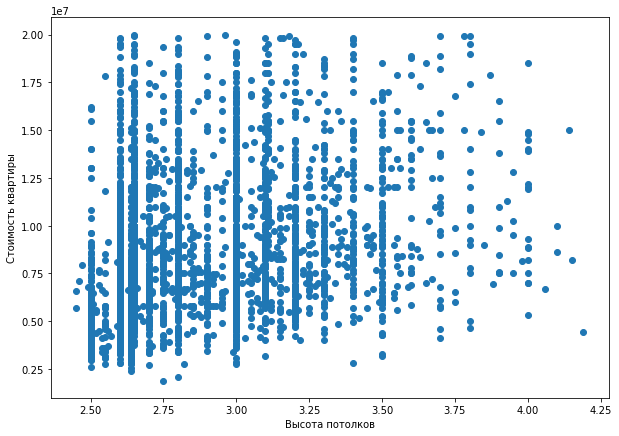

Коэффициент корреляции между высотой потолка в квартире и ее ценой
0.2723843515540132


In [68]:
plt.figure(figsize=(10, 7))
plt.scatter(piter_center['ceiling_height'], piter_center['last_price'])
plt.xlabel('Высота потолков')
plt.ylabel('Стоимость квартиры')
plt.show()

print('Коэффициент корреляции между высотой потолка в квартире и ее ценой')
print(piter_center['ceiling_height'].corr(piter_center['last_price']))

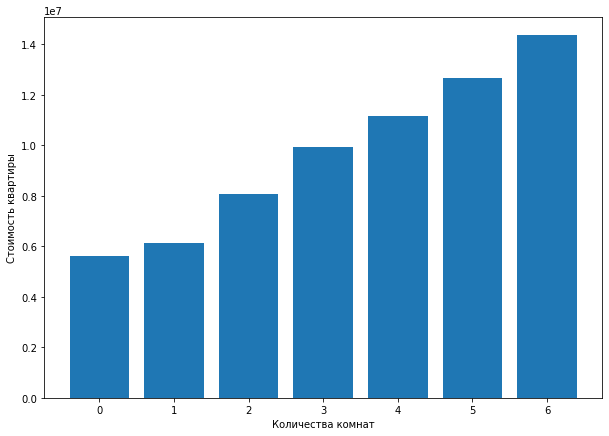

In [69]:
plt.figure(figsize=(10, 7))
#plt.scatter(piter_center['rooms'], piter_center['last_price'])

plt.bar(range(0, 7), piter_center.groupby('rooms')['last_price'].mean())
plt.xlabel('Количества комнат')
plt.ylabel('Стоимость квартиры')
plt.show()


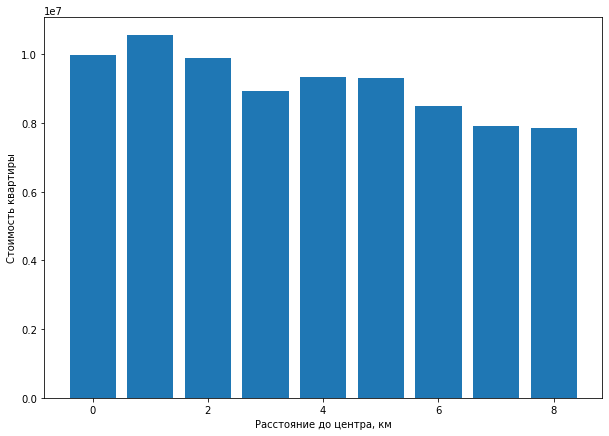

Коэффициент корреляции между расстоянием до центра и ее ценой
-0.18026221244038734


In [70]:
plt.figure(figsize=(10, 7))
#plt.scatter(piter_center['city_center_nearest'], piter_center['last_price'])

plt.bar(range(0, 9), piter_center.groupby('city_center_nearest')['last_price'].mean())
plt.xlabel('Расстояние до центра, км')
plt.ylabel('Стоимость квартиры')
plt.show()

print('Коэффициент корреляции между расстоянием до центра и ее ценой')
print(piter_center['city_center_nearest'].corr(piter_center['last_price']))

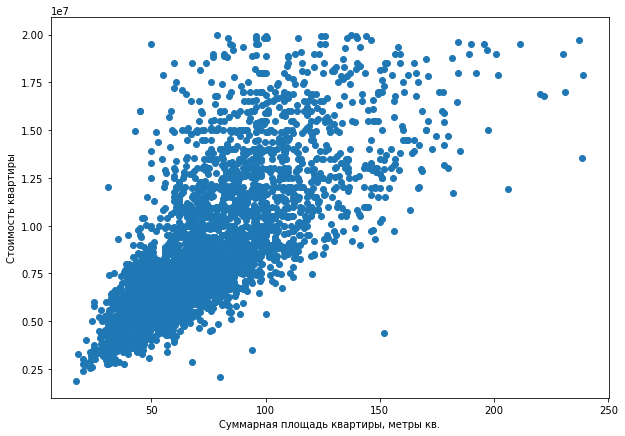

Коэффициент корреляции между площади квартиры и ее ценой
0.7412330705461193


In [71]:
plt.figure(figsize=(10, 7))
plt.scatter(piter_center['total_area'], piter_center['last_price'])

plt.xlabel('Суммарная площадь квартиры, метры кв.')
plt.ylabel('Стоимость квартиры')
plt.show()

print('Коэффициент корреляции между площади квартиры и ее ценой')
print(piter_center['total_area'].corr(piter_center['last_price']))

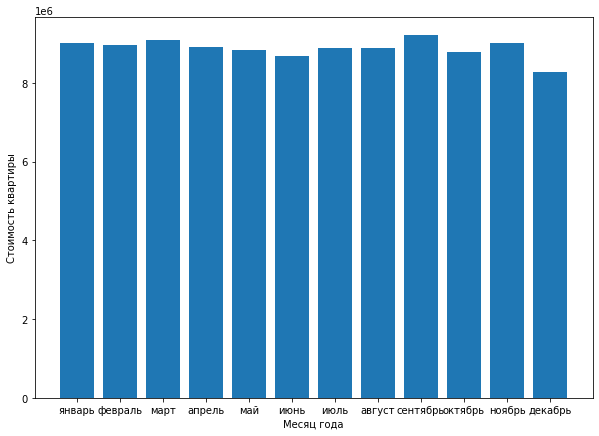

In [72]:
plt.figure(figsize=(10, 7))
#plt.scatter(piter_center['month_name'], piter_center['last_price'])

plt.bar(mon, piter_center.groupby('month')['last_price'].mean())
plt.xlabel('Месяц года')
plt.ylabel('Стоимость квартиры')
plt.show()

In [73]:
piter_center.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,meters_price,time_data,month,weekday,year,month_name,day_name,floor_name,living_to_total,kitchen_to_total
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14,32.0,13,False,...,100000.00,2018-06-19,6,1,2018,Июнь,Вторник,другой,0.32,0.41
24,8,6500000.0,97.2,2015-10-31T00:00:00,2,2.60,3,46.5,1,False,...,66872.43,2015-10-31,10,5,2015,Октябрь,Суббота,первый,0.48,0.20
35,6,15500000.0,149.0,2017-06-26T00:00:00,5,3.11,5,104.0,4,False,...,104026.85,2017-06-26,6,0,2017,Июнь,Понедельник,другой,0.70,0.11
52,20,11795000.0,136.0,2017-09-22T00:00:00,6,3.00,2,94.0,2,False,...,86727.94,2017-09-22,9,4,2017,Сентябрь,Пятница,последний,0.69,0.08
61,18,7990000.0,74.0,2017-08-24T00:00:00,2,2.60,4,43.0,4,False,...,107972.97,2017-08-24,8,3,2017,Август,Четверг,последний,0.58,0.27


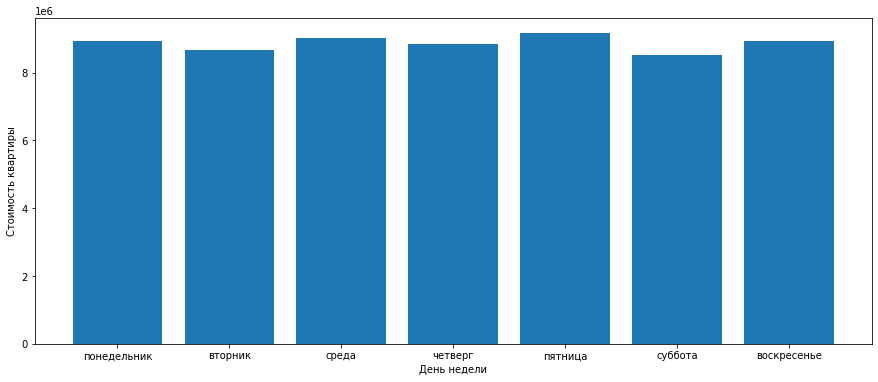

In [74]:
plt.figure(figsize=(15, 6))
#plt.scatter(piter_center['day_name'], piter_center['last_price'])
#day = ['понедельник', 'вторник', 'среда', 'четверг', 'пятница', 'суббота', 'воскресенье']
plt.bar(day, piter_center.groupby('day_name')['last_price'].mean())

plt.xlabel('День недели')
plt.ylabel('Стоимость квартиры')
plt.show()

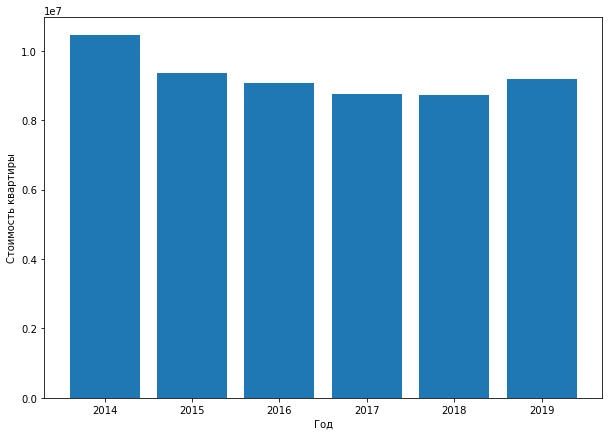

In [75]:
plt.figure(figsize=(10, 7))
#plt.scatter(piter_center['year'], piter_center['last_price'])

plt.bar(range(2014, 2020), piter_center.groupby('year')['last_price'].mean())
plt.xlabel('Год')
plt.ylabel('Стоимость квартиры')
plt.show()

**вывод**

На ценообразование квартир в Питере в центровой зоне все также имеет влияение общая площадь квартиры, в меньшей степени - количество комнат, не влияют: день, месяц, год.

**ОБЩИЙ ВЫВОД**

проведена обработка данных, заполненны пропуски в данных:
* в некоторых местах данные заменены на медианные значения, сгруппированные по 2м показателям
* некоторые значения заменены на 0, где-то на значения "неизвестно"
* пропуски в значениях прудов, парков, расстояний до ажропортов - решила не придумывать и не заполнять, тем более что на дальнейшие расчеты это не влияет.

при дальнейшем рассмотрении данных хорошо видно следующее:

для необработанных данных:
* средняя цена на квартиру ~4млн. рублей
* средняя площадь квартиры ~50 кв. метров
* среднее кол-во комнат - 2
* средняя цена за кв. метр около 100 тысяч рублей
* средняя высота потолков -2.50 метров

**Задание 1**

Исследованы значения продажи квартиры (дни), установлено:
* медианное значение - 74 дня
* среднее значение - 156 дней
* аномально быстрыми продажами считаются продажи, совершенные менее чем за 30 дней
* аномально долгими - те, что больше 200 дней

**Задание 2**

Исследование влияния параметров на цену квартир:
* суммарная площадь квартир имеет сильное влияние на стоимость квартиры
* количество комнат также имеет влияние, однако опосредованно, через площадь квартиры
* расстояние до центра имеет обратную зависимоть - чем ближе к центру, тем выше стоимость
* дата выставления объявления не влияет на цену квартиры

**Задание 3**

* выбраны 10 населенных пунктов с самым большим кол-вом объявлений
* посчитано среднее значение цены квадратного метра
* найдено минимальное значение стоимости кв. метра ( СПБ - 104761 тыс. руб)
* найдено максимальное значение стоимости кв. метра (Выборг - 58307 тыс. руб)

**Задание 4**

* определен центр города - 8км
* посчитана средняя стоимость для каждого км

**Задание 5**

для отфильтрованых значений Санкт-Петербурга в пределах 8 км
* суммарная площадь сместилась в сторону увеличения - то есть если раньше медиана была в районе 50кв.метров, а теперь - ближе к 100кв.метрам.
* средняя стоимость квартиры увеличилась с 4млн рублей до 10 млн. рублей
* количество комнат - среднее значение было около 2х комнат, теперь сместилось к 3м комнатам.
* высота потолков осталась без изменений
